# Character-level LSTM with PyTorch

An RNN model will be trained to generate new text character by character. Both the text used for training and the generated text will be analyzed with some statistical functions (e.g., for assessing readability), so that we can evaluate the statistical similarity between the training data and the generated sample.

In [1]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00


In [2]:
!pip install torchmetrics transformers>=4.0

In [3]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import textstat
import matplotlib.pyplot as plt
import transformers
import torchmetrics
from torchmetrics.functional.text.bert import bert_score
from nltk.translate.bleu_score import sentence_bleu

In [4]:
transformers.logging.set_verbosity_error()

# Test BERT-Score
bert_score(['The sky is blue.'], ["The sky is yellow."])['f1']

/usr/local/lib/python3.8/dist-packages/torchmetrics/functional/text/bert.py:342: UserWarning: The argument `model_name_or_path` was not specified while it is required when default `transformers` model are used.It is, therefore, used the default recommended model - roberta-large.
  warn(


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.9957970976829529

In [5]:
# Test BLEU score
sentence_bleu(['The sky is blue.'], 'The sky is yellow.', weights=(0.5, 0.5))

0.6763995415945232

In [6]:
def calc_text_statistics(text):
  return {
      'Flesch reading ease': textstat.flesch_reading_ease(text),
      'Linsear-Write Formula': textstat.linsear_write_formula(text),
      'Dale-Chall readability score': textstat.dale_chall_readability_score(text),
  }

## Training data

In [7]:
with open('shakespeare.txt', 'r') as f:
    text = f.read()

In [8]:
calc_text_statistics(text)

{'Flesch reading ease': 88.06,
 'Linsear-Write Formula': 4.636363636363637,
 'Dale-Chall readability score': 5.31}

### Characters tokenization

We need to be able to convert each character into an integer token.

In [9]:
chars_in_text = tuple(set(text))

int2char = dict(enumerate(chars_in_text))
char2int = {ch: ii for ii, ch in int2char.items()}

encoded_text = np.array([char2int[ch] for ch in text])

In [10]:
# Encoding and then decoding produces the initial character
print(int2char[char2int['X']])

X


The LSTM accepts only one-hot encoded vectors, so we prepare a function that takes as input an array of encoded characters and outputs an array of one-hot vectors.

In [11]:
def to_one_hot(char_encoding):
    one_hot = np.zeros(len(int2char))
    one_hot[char_encoding] = 1
    return one_hot

# Test
to_one_hot(12)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Train, validation and test split

In [12]:
split1 = int(encoded_text.shape[0] * 0.8)  # 80% for training
split2 = int(encoded_text.shape[0] * 0.9)  # 10% for testing

train_data, val_data, test_data = np.split(encoded_text, [split1, split2])
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(892315,)
(111539,)
(111540,)


## Mini-batches generation

We define a function that uses the text encodings to create input and target arrays, where the targets are the same as the inputs, but shifted over one character.

In [13]:
# Divide the array of encodings into batches.
def get_batches(encodings_arr, sequences_per_batch, chars_per_sequence):
    batch_size = sequences_per_batch * chars_per_sequence
    number_of_batches = len(encodings_arr)//batch_size
    
    # Keep only enough characters to make full batches
    encodings_arr = encodings_arr[:number_of_batches * batch_size]
    
    # Split the array into sequences by reshaping it into `sequences_per_batch` rows.
    encodings_arr = encodings_arr.reshape((sequences_per_batch, -1))
    
    for n in range(0, encodings_arr.shape[1], chars_per_sequence):        
        # The features
        x = encodings_arr[:, n:n+chars_per_sequence]
        
        # The targets, shifted by one
        y = np.zeros_like(x)
        
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], encodings_arr[:, n+chars_per_sequence]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], encodings_arr[:, 0]
        
        yield x, y

#### Test the mini-batches generation

In [14]:
first_batch = next(get_batches(encoded_text, 3, 100))
print(f'Every mini-batch is a tuple of {len(first_batch)} arrays.')
print(f'First one contains features and in this case has shape {first_batch[0].shape}')
print(f'Second one contains targets and in this case has shape {first_batch[1].shape}')

Every mini-batch is a tuple of 2 arrays.
First one contains features and in this case has shape (3, 100)
Second one contains targets and in this case has shape (3, 100)


In [15]:
x, y = first_batch
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[28 42 49 63  2 34 59 42  2 42]
 [34  2 29 25  2 34 46 60 24 64]
 [63  0 34 35 15 54 29 25  6  6]]

y
 [[42 49 63  2 34 59 42  2 42  9]
 [ 2 29 25  2 34 46 60 24 64 14]
 [ 0 34 35 15 54 29 25  6  6 34]]


The data is correctly shifted over one step for `y`.

---
## Model definition

In [16]:
class CharRNN(nn.Module):
    def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden

        char_embedding_size = len(int2char) # size of the one-hot vectors representing characters
        self.lstm = nn.LSTM(char_embedding_size, n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, char_embedding_size)
        
        self.init_weights()
      
    
    def forward(self, x, hc):
        # Get x, and the new hidden state (h, c) from the lstm
        x, (h, c) = self.lstm(x, hc)
        
        x = self.dropout(x)
        
        # Stack up LSTM outputs
        x = x.reshape(x.size()[0] * x.size()[1], self.n_hidden)
        
        x = self.fc(x)
        
        # Return x and the hidden state (h, c)
        return x, (h, c)
    
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character and the hidden state, predict the next character.
        
            Returns the predicted character and the new hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[to_one_hot(char2int[char])]], dtype=np.float32)
        
        inputs = torch.from_numpy(x)
        
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([h_item.data for h_item in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(int2char))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return int2char[char], h
    
    def init_weights(self):
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())
        

## Sampling

To sample from the trained model, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and get another predicted character. By keeping doing this we'll generate a bunch of text.

### Top K sampling

Our predictions come from a categorical probability distribution over all the possible characters. We can make the sample text and make it more reasonable to handle (with less variables) by only considering some $K$ most probable characters. This will prevent the network from giving us completely absurd characters while allowing it to introduce some noise and randomness into the sampled text.

In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

In [17]:
def generate_sample(net, sample_length, prime='The ', top_k=None):
    cuda = torch.cuda.is_available()
    if cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()
    
    chars = [ch for ch in prime]
    
    h = net.init_hidden(1)
    for ch in prime:
        char, h = net.predict(ch, h, cuda=cuda, top_k=top_k)

    chars.append(char)
    
    for ii in range(sample_length):
        char, h = net.predict(chars[-1], h, cuda=cuda, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

## Network training and evaluation

In [18]:
EPOCHS = 35
N_SEQS = 128
N_STEPS = 100
LR = 3e-4
CLIP = 5  # gradient clipping
CUDA = torch.cuda.is_available()

criterion = nn.CrossEntropyLoss()

def create_and_train_model():
    net = CharRNN(n_hidden=512, n_layers=2)
    print(net, '\n')

    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=LR)

    if CUDA:
        net.cuda()

    chart_train_losses = []
    chart_val_losses = []
    chart_val_f1_bert_scores = []
    chart_val_bleu_scores = []

    train_counter = 0
    for e in range(EPOCHS):
        h = net.init_hidden(N_SEQS)

        for x, y in get_batches(train_data, N_SEQS, N_STEPS):
            train_counter += 1
            net.train()
            
            # One-hot encode our data and make them Torch tensors
            x = np.array([
                [to_one_hot(c) for c in seq] for seq in x
            ], dtype=np.float32)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if CUDA:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
            
            loss = criterion(
                output,
                targets.view(N_SEQS*N_STEPS).type(torch.cuda.LongTensor if CUDA else torch.LongTensor)
            )

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), CLIP)

            opt.step()
            
            if train_counter % 25 == 0:

                # Get validation loss
                val_h = net.init_hidden(N_SEQS)
                val_losses = []
                for x, y in get_batches(val_data, N_SEQS, N_STEPS):
                    # One-hot encode our data and make them Torch tensors
                    x = np.array([
                        [to_one_hot(c) for c in seq] for seq in x
                    ], dtype=np.float32)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if CUDA:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(
                        output,
                        targets.view(N_SEQS*N_STEPS).type(torch.cuda.LongTensor if CUDA else torch.LongTensor)
                    )
                
                    val_losses.append(val_loss.item())
                
                # Let's divide the text into chunks and see how the model performs at predicting the next chunk.
                val_text = ''.join([int2char[n] for n in val_data])
                val_text = val_text[:500]  # for performance reasons

                chunk_size = 100
                number_of_chunks = len(val_text)//chunk_size

                val_f1_bert_scores = []
                val_bleu_scores = []
                chunks = [val_text[i:i+chunk_size] for i in range(0, number_of_chunks*chunk_size, chunk_size)]
                for k in range(len(chunks)-1):
                    predicted_text = generate_sample(net, chunk_size, prime=''.join(chunks[:k+1]))
                    predicted_text = predicted_text[-chunk_size:]
                    target_text = chunks[k+1]
                    # Calculate metrics for comparing target and predicted text
                    val_f1_bert_scores.append(
                        bert_score([predicted_text], [target_text])['f1']
                    )
                    val_bleu_scores.append(
                        sentence_bleu([target_text], predicted_text, weights = (0.5, 0.5))
                    )

                chart_train_losses.append(loss.item())
                chart_val_losses.append(np.mean(val_losses))
                chart_val_f1_bert_scores.append(np.mean(val_f1_bert_scores))
                chart_val_bleu_scores.append(np.mean(val_bleu_scores))
                print("Epoch: {}/{}...".format(e+1, EPOCHS),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}...".format(np.mean(val_losses)),
                      "Val BERTScore: {:.4f}...".format(np.mean(val_f1_bert_scores)),
                      "Val BERTScore std: {:.4f}".format(np.std(val_f1_bert_scores)),
                      "Val BLEU score: {:.4f}...".format(np.mean(val_bleu_scores)),
                      "Val BLEU score std: {:.4f}".format(np.std(val_bleu_scores)))

    print('')
    fig, ax = plt.subplots()
    ax.plot(chart_train_losses, label='Train loss')
    ax.plot(chart_val_losses, label='Val loss')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(chart_val_f1_bert_scores, label='Val BERTScore')
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(chart_val_bleu_scores, label='Val BLEU score')
    ax.legend()
    plt.show()

    return net

In [19]:
def eval_trained_model(net):
    net.eval()

    test_h = net.init_hidden(N_SEQS)
    test_losses = []
    for x, y in get_batches(test_data, N_SEQS, N_STEPS):
        # One-hot encode our data and make them Torch tensors
        x = np.array([
            [to_one_hot(c) for c in seq] for seq in x
        ], dtype=np.float32)
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        
        test_h = tuple([each.data for each in test_h])
        
        inputs, targets = x, y
        if CUDA:
            inputs, targets = inputs.cuda(), targets.cuda()

        output, test_h = net.forward(inputs, test_h)
        test_loss = criterion(
            output,
            targets.view(N_SEQS*N_STEPS).type(torch.cuda.LongTensor if CUDA else torch.LongTensor)
        )

        test_losses.append(test_loss.item())
    
    print(f'\nTest Loss: {round(np.mean(test_losses), 4)}')

    # ERROR ANALYSIS

    # Let's divide the text into chunks and see how the model performs at predicting the next chunk.
    test_text = ''.join([int2char[n] for n in test_data])
    test_text = test_text[:4000]  # for performance reasons

    chunk_size = 100
    number_of_chunks = len(test_text)//chunk_size
    
    results = []
    
    chunks = [test_text[i:i+chunk_size] for i in range(0, number_of_chunks*chunk_size, chunk_size)]
    for k in range(len(chunks)-1):
        prime = ''.join(chunks[:k+1])
        predicted_text = generate_sample(net, chunk_size, prime=prime)
        predicted_text = predicted_text[-chunk_size:]
        target_text = chunks[k+1]
        bleu_score = sentence_bleu([target_text], predicted_text, weights = (0.5, 0.5))
        results.append({
            'prime': prime,
            'target_continuation': target_text,
            'predicted_continuation': predicted_text,
            'bleu_score': bleu_score,
        })

    import json
    print('\nGood results:')
    print(json.dumps(sorted(results, key=lambda res: res['bleu_score'], reverse=True)[:5], indent=4))
    print('\nBad results:')
    print(json.dumps(sorted(results, key=lambda res: res['bleu_score'], reverse=False)[:5], indent=4))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
) 

Epoch: 1/35... Loss: 3.4025... Val Loss: 3.3916... Val BERTScore: 0.9696... Val BERTScore std: 0.0025 Val BLEU score: 0.2771... Val BLEU score std: 0.0409
Epoch: 1/35... Loss: 3.2651... Val Loss: 3.2732... Val BERTScore: 0.9716... Val BERTScore std: 0.0008 Val BLEU score: 0.2867... Val BLEU score std: 0.0398
Epoch: 2/35... Loss: 3.1158... Val Loss: 3.1105... Val BERTScore: 0.9734... Val BERTScore std: 0.0017 Val BLEU score: 0.3616... Val BLEU score std: 0.0382
Epoch: 2/35... Loss: 2.9180... Val Loss: 2.9194... Val BERTScore: 0.9732... Val BERTScore std: 0.0012 Val BLEU score: 0.3759... Val BLEU score std: 0.0211
Epoch: 2/35... Loss: 2.7492... Val Loss: 2.7427... Val BERTScore: 0.9754... Val BERTScore std: 0.0021 Val BLEU score: 0.4224... Val BLEU score std: 0.0635
Epoch: 3/35... Loss: 2.6072... Val Loss:

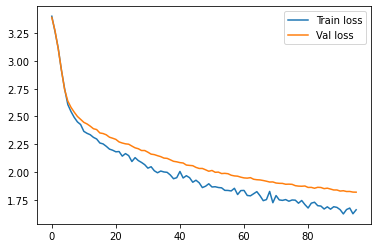

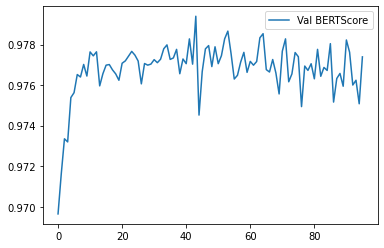

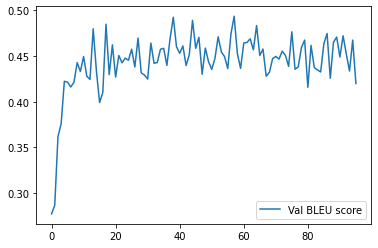


====


Test Loss: 1.8827

Good results:
[
    {
        "prime": "?\n\nGREMIO:\nGood morrow, neighbour Baptista.\n\nBAPTISTA:\nGood morrow, neighbour Gremio.\nGod save you, gentlemen!\n\nPETRUCHIO:\nAnd you, good sir! Pray, have you not a daughter\nCall'd Katharina, fair and virtuous?\n\nBAPTISTA:\nI have a daughter, sir, called Katharina.\n\nGREMIO:\nYou are too blunt: go to it orderly.\n\nPETRUCHIO:\nYou wrong me, Signior Gremio: give me leave.\nI am a gentleman of Verona, sir,\nThat, hearing of her beauty and her wit,\nHer affability and bashful modesty,\nHer wondrous qualities and mild behavior,\nAm bold to show myself a forward guest\nWithin your house, to make mine eye the witness\nOf that report which I so oft have heard.\nAnd, for an entrance to my entertainment,\nI do present you with a man of mine,\nCunning in music and the mathematics,\nTo instruct her fully in those sciences,\nWhereof I know she is not ignorant:\nAccept of him, or else you do me wrong:\nHis name is Licio, 

In [ ]:
torch.manual_seed(0)
net = create_and_train_model()
print('\n====\n')
eval_trained_model(net)

In [ ]:
torch.manual_seed(42)
net = create_and_train_model()
print('\n====\n')
eval_trained_model(net)

In [ ]:
torch.manual_seed(512)
net = create_and_train_model()
print('\n====\n')
eval_trained_model(net)

In [ ]:
sample = generate_sample(net, 2000, top_k=5)

print(sample)

In [ ]:
calc_text_statistics(sample)

## Save the model

In [ ]:
torch.save(net.state_dict(), 'trained_model.pth')
from google.colab import files
files.download('trained_model.pth')